Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning openCypher - Basic Read Queries

This notebook is the first in a series of notebooks that walk through how to write queries using openCypher.  In this notebook, we will examine the basics of openCypher read queries and how these queries fit into the "Find", "Filter", "Format" paradigm.  Let's begin by loading some sample data into our Neptune cluster.  




## Getting Started

For these notebooks, we will be leveraging a dataset from the book [Graph Databases in Action](https://www.manning.com/books/graph-databases-in-action?a_aid=bechberger) from Manning Publications.  


**Note:** These notebooks do not cover data modeling or building a data loading pipeline.  If you would like a more detailed description about how this dataset is constructed and the design of the data model came from, then please read the book.

To get started, the first step is to load data into the cluster.  Assuming the cluster is empty, this can be accomplished by running the cell below which will load the Dining By Friends dataset, installed as part of the notebook.

### Loading Data

In [ ]:
%seed --model Property_Graph --dataset dining_by_friends --run

### Looking at our graph data

Now that we have loaded our data, let's take a moment to look at what our data model looks like:


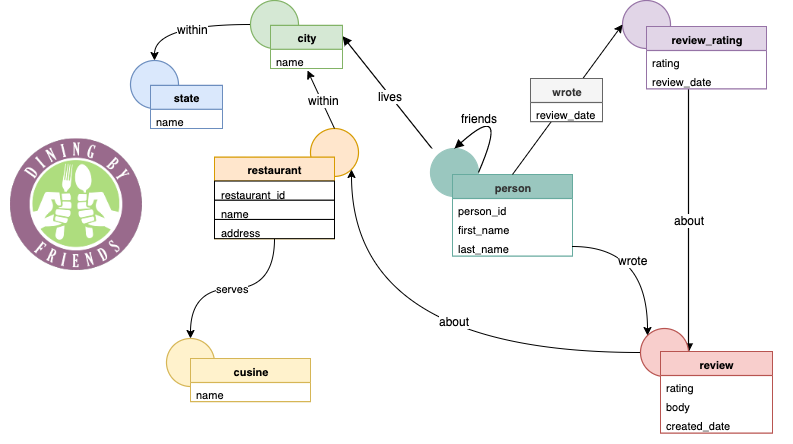

<table>
    <tr><th colspan=3 style="text-align: center">Element (Node/Edge) Counts</th>
    </tr>
<tr><td style="width:40%">
    
|Node Label|Count|
|:--|:--|
|review|109|
|restaurant|40|
|cuisine|24|
|person|8|
|state|2|
|city|2|
    
</td>
    <td></td>
    <td style="width:40%">

|Edge Label|Count|
|:--|:--|
|wrote|218|
|about|218|
|within|84|
|serves|80|
|friends|20|
|lives|16|

</td></tr> </table>

This dataset represents a fictitious, but realistic, restaurant recommendation application that contains:

* Users, represented by `person` nodes
* Users connected to Users via `friends` edges
* Restaurants and their associated information (`city`, `state`, `cusine`)
* Reviews include the body and ratings
* Ratings of reviews (helpful/not helpful)

This application contains three main aspects to the data it collects.  First, it contains a social network consisting of `person` nodes connected to other `person` nodes via a `friends` edge.  Second, it contains a restaurant review aspect consisting of `restaurant` nodes, information about those restaurants (`city`/`state`/`cuisine`), and `review` nodes for that restaurant.  The third, and final aspect, consists of a personalization component where a `person` can rate a `review`, which allows for better recommendations based on a person's preferences.

Throughout this set of notebooks, we will leverage the different aspects of this data to highlight different fundamental types of common property graph queries, namely neighborhood traversals, hierarchies, paths, and collaborative filtering.

Now let's get started.

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

In [ ]:
node_labels = '{"person":"first_name","city":"name","state":"name","restaurant":"name","cusine":"name"}'


## Finding your Data

When working with openCypher, the most common usage of the language is to find data.  openCypher accomplishes this using a couple of clauses:

* `MATCH` - specifies the pattern of data to look for, see below for the pattern syntax
* `RETURN` - defines what and how the data will be returned to the user
* `LIMIT` - while not required, this is useful to minimze the data returned by specifying the maximum number of matching patterns returned

The `MATCH` clause is a fundamental part of every query.  It uses an ASCII art-based syntax to define the pattern of nodes and edges that you would like to match within the graph.  These matches are then used as the basis for the filter and format portions of the query.   

The pattern matching syntax used in is highlighted in the table below.

#### Pattern Matching Syntax

|   openCypher Pattern|Description|
|:--|:--|
|`( )`|A node|
|`[ ]`|An edge|
|`-->`|Follow outgoing edges from a node|
|`<--`|Follow incoming edges from a node|
|`--`|Follow edges in either direction|
|`-[]->`|Include the outgoing edges in the query (to check a label or property for example)|
|`<-[]-`|Include the incoming edges in the query (to check a label or property for example)|
|`-[]-` |Include edges in either direction in the query|
|`-[]->( )`|The node on the other end of an outgoing edge|
|`<-[]-()`|The node on the other end of an incoming edge|


Looking at the syntax above, you may be curious about the concept of incoming and outgoing edges.  In property graphs, all edges are defined as having a direction, meaning that they start at one node and end at another.  However, graph query languages such as openCypher allow you to specify patterns where you traverse these edges in either direction. 

Now that we have a basic understanding of openCypher's pattern matching syntax, let's take a look at how this is applied to answer some common graph query patterns.

### Finding Nodes

The simplest pattern you can do in openCypher is to match nodes.  In openCypher patterns, nodes are represented by parentheses (`()`).

Patterns, or elements within a pattern, can be associated with a variable by assigning them within the related portion of the syntax.  For nodes, this means adding it within the parentheses such as in `(n)` where `n` is the variable name.  When we put a variable within a pattern, this portion of the pattern is then available to us later in the query for additional operations, such as filtering or formatting to return to the user, as shown below.

Execute the query below to search for nodes and assign them to a variable `n` (`MATCH (n)`), return the nodes labeled `n` (`RETURN n`), but limit the number returned to 10.

In [ ]:
%%oc -d $node_labels
MATCH (n)  //find me nodes and label them 'n'
RETURN n   //return 'n'
LIMIT 10   //return only 10 results

**Note:** If no label is applied to a portion of the pattern, then that portion will be used for pattern matching but will not be available for additional operations, as we will see in the next query.

### Finding Edges

The example above works, but it does not leverage the connections within the data, represented by edges in our graph. Edges make graph databases a powerful asset for working with connected data.  

To perform a search across multiple nodes and edges, we need to use our pattern to specify how the nodes and edges are related using the following syntax:


|   openCypher Pattern|Description|
|:--|:--|
|`-->`|Follow outgoing edges from a node|
|`<--`|Follow incoming edges from a node|
|`--`|Follow edges in either direction|
|`-[]->`|Include the outgoing edges in the query (to check a label or property for example)|
|`<-[]-`|Include the incoming edges in the query (to check a label or property for example)|
|`-[]-` |Include edges in either direction in the query|

Execute the query below to search for node-edge->node patterns, assign the edges to a variable `r` (`MATCH ()-[r]->()`), and return 10 edges labeled `r` (`RETURN r`).

In [ ]:
%%oc  -d $node_labels
MATCH ()-[r]->() //find me all node-edge->node patterns
RETURN r         //return the edge
LIMIT 10         //return only 10 results

In the example above, we specified using outgoing edges, via the arrow direction `()-[r]->()`, but we could have also chosen to look for patterns using only incoming edges, `()<-[r]-()`, or ignoring edge direction, `()-[r]-()`.  

To build more complex patterns, we can use these basic constructs to link together multiple levels of connections to find more complex patterns.  In the example below, we have extended our previous query to return 10 nodes that have both incoming and outgoing edges, by specifying a `node-edge->node<-edge-node` pattern.

In [ ]:
%%oc  -d $node_labels
MATCH ()-[]->(n)<-[]-() //find me all node-edge->node<-edge-node patterns
RETURN n         
LIMIT 10         

In the example above, we have returned matches based on a series of connected nodes and edges.  When working with graphs, a series of connected nodes and edges may also be referred to as a 'path'.  Often when we are looking for patterns within our graph, we would like to return not just a node or edge within the pattern but the path containing how these items are connected.


### Finding Paths

To find paths within our graph, we combine two constructs we have already learned: pattern matching and variables, to specify that we want the path returned.  In our previous queries, we assigned a node or edge in our pattern to a variable.  When returning a path, we assign the entire pattern to a variable, as seen below where we assign the path to a variable `p`.  

Once we have assigned our path to the variable, we can return this as we have previous variables, except now our returned values will contain the `node-edge->node<-edge-node` information for the path that was matched.


In [ ]:
%%oc -d $node_labels
MATCH p=()-[]->(n)<-[]-() //assign my node-edge->node<-edge-node patterns to a variable 'p'
RETURN p 
LIMIT 10

## Filtering your Data

So far, we have learned how to find specific patterns within our graph based on how the nodes and edges connect.  However, most of the time you will want to use attributes of the nodes and edges to filter the results to return a more specific subset of data.  

We accomplish this using the `WHERE` clause.  Within the `WHERE` clause, there are a variety of operators available to perform logical operations and comparisons of the data.  Below is a listing of the operators supported by openCypher.

**Operators**

|Type|Operators|
| ----------- | ----------- |
|General|`DISTINCT, x.y (property access)`|
|Math|`+`, `-`, `*`, `/`|
|Comparison|`=`, `>`, `<`, `<>`, `<=`, `>=`, `IS NULL`, `IS NOT NULL`|
|Boolean|`AND`, `OR`, `NOT`, `XOR`|
|String|`STARTS WITH`, `ENDS WITH`, `CONTAINS`, `+`|
|LIST|`+`, `IN`, `[]`|


In the next section, we will look at some common ways to apply filters using these operators.  

### Filtering Nodes by Label

One of the most common items you will want to filter on will be the label(s) associated with a node.  There are two methods for adding label filters to a query.  You can either:

* Inline the filter as part of the match clause, which is done by adding a colon (`:`) followed by one or more label names (separated by a `|`) 
* Use the `labels()` function in a `WHERE` clause to filter.  

Both of these will produce identical results so whether you choose one versus the other is a decision for the query writer.  Below, we have included examples of both:

#### Filtering using inline filters

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN d 
LIMIT 10

#### Filtering using `labels()` and the `WHERE` clause

In [ ]:
%%oc -d $node_labels
MATCH (d)
WHERE 'person' IN labels(d)
RETURN d
LIMIT 10

One item you might notice is the use of `IN` to find if the label exists in the node instead of an equality (`=`) operator.  In openCypher, nodes can have multiple labels associated with them.  As a result, the `labels()` function returns a list of labels and the `IN` clause allows us to find a specific label inside that list.  

### Filtering Edge by Type
Another common item you to filter on is the type or label associated with an edge. As with nodes, there are two methods for adding edge label filters to a query, as shown here: 

* Inline the filter as part of the match clause, which is done by adding a colon (`:`) followed by one or more type names (separated by a |) 
* Use the `type()` function in a `WHERE` clause to filter. 

As with nodes, these will produce identical results so whether you choose one versus the other is a decision for the query writer.  Below we have included examples of both:

#### Filtering using inline filters

In [ ]:
%%oc -d $node_labels
MATCH p=(d:person)-[:friends]->()
RETURN p
LIMIT 10

#### Filtering using `type()` and `WHERE`

In [ ]:
%%oc -d $node_labels
MATCH p=(d:person)-[r]->()
WHERE type(r)='friends'
RETURN p
LIMIT 10

Unlike when we filtered using `labels()`, when we use `type()` to filter edges we do not need to use `IN`.  Edges can only have a single label associated with them, so the `type()` function will return a single value, not a list.  Due to this difference, we can do a direct equality comparison.

### Finding by Property

The next common use case for filtering is to be able to filter on attribute values. 

As with node and edge labels, there are two methods for adding edge label filters to a query. Once again our options are either: 

* Inline the filter as part of the match clause, which is done by adding curly brackets containing the key/value you want to filter on (`{first_name: 'Dave'}`)
* Use the `WHERE` clause to filter using the operators

Below, we have included examples of both:

In [ ]:
%%oc -d $node_labels
MATCH (d)
WHERE d.first_name='Dave'
RETURN d 
LIMIT 10

Alternatively, you include equality filters inline with the pattern by putting them into curly brackets (`{}`) with the property key name followed by the value, as shown below:

In [ ]:
%%oc -d $node_labels
MATCH (d {first_name: 'Dave'})
RETURN d 
LIMIT 10

In these two examples, both return the same results and are interpreted by the engine as the same query, so this begs the question of when to choose which one?

Part of the answer to that question comes down to the preference of the query writer. However, here are some general guidelines:

* Inlining of filters works only on equality filters for one or more properties.  If you need to do non-equality filters (e.g. not equals, greater than, less than, `IN`) then you should use a `WHERE` clause
* `WHERE` clauses allow more complex filtering using `AND`, `OR`, and `NOT` to build up more complex expressions
* `WHERE` clauses support List and Pattern comprehension (discussed later) where in-lining filters does not

### Filtering on Existence
Another common need when filtering data is to check for the existence of an attribute or additional piece of topology.  This is most commonly accomplished using the `exists()` function as shown below.

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
WHERE exists(d.last_name)
RETURN d 
LIMIT 10

You can also use the `exists()` function with the `NOT` predicate to filter on patterns that do not exist, such as in the example below where we find all `person` nodes that do not have a property `age`.

**Note** - With this dataset it will return all 8 people as there is no `age` property in the data

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
WHERE NOT exists(d.age)
RETURN d 
LIMIT 10

In the examples above, we checked the existence of a property using the `exists()` function.  In addition to properties, we can also check for the existence of patterns, using the pattern matching syntax, as part of the `WHERE` clause.  

Below, we can see how we can leverage pattern matching to find all `person` nodes that do not have anyone who has connected to them with an incoming `friends` edge.

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
WHERE NOT (d)<-[:friends]-()
RETURN d 
LIMIT 10

## Formatting Results

Having gone through the basics of finding and filtering data with openCypher, let's take a look at the last step, formatting our results.  All openCypher read queries, and almost all mutation queries, end with a `RETURN` clause.  This clause is used to specify what aspects of the data are returned and in what format.


### Returning all values

The simplest way to return data is to return all values specified in the query.  This can be accomplished by specifying a wildcard `*` in the `RETURN` clause as shown here.

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN *
LIMIT 10

While this is easy to write, it is not very efficient, either in terms of the work the engine has to do to retrieve all the values or the amount of data that has to be transmitted over the wire.

### Returning property values

Most often, you want to be specific about the data elements (node/edges), attributes, or a combination of both, that a query returns.  This provides for efficient processing, both at the database and client level, and efficient data transmission, since we are only retrieving, processing, and sending what is needed.  

To accomplish this, we use the `RETURN` clause to specify the variable associated with a node/edge/path or we specify the property or properties of elements using a `<variable>.<attribute>` syntax.  

Below we have two queries, the first returns the person's first name and the second returns the first and last name values.

**Note:** If you would like to assign a specific key to the values returned, you can rename them using the `AS` modifier, e.g., If you wanted to return the `first_name` as `name` you'd accomplish this via `RETURN d.first_name AS name`.  If it is not specified, then the key name will default to the element or property variable name.


In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN d.first_name
LIMIT 10

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN d.first_name, d.last_name
LIMIT 10

### Returning unique values

To return unique values in the results, use the `DISTINCT` clause in the `RETURN` statement to return just the unique values for the specified propery.

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN DISTINCT d.last_name
LIMIT 10

### Returning static values

While not as common as some of the other options shown here, openCypher also allows you to return static values for any matches.  In the query below, we return a static literal `true` for each matched node.

In [ ]:
%%oc -d $node_labels
MATCH (d)
RETURN true
LIMIT 1

### Projecting new return values

In addition to returning existing values, we can also perform operations on those values using functions, which will be discussed in the third notebook), such as `min()`, `max()`, `toUpper()`, or perform other operations using primitives, such as concatenating strings.  

In the example below, we show how you can return a full name by concatenating the `first_name` and `last_name` using one these primitive operators.  The exact primitives available and their behavior vary depending on the incoming data types.

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN d.first_name + ' ' + d.last_name AS full_name
LIMIT 10

### Constructing complex return types

In addition to returning simple key-value pairs, the `RETURN` clause can construct more complex response types such as maps.  This is a common requirement, especially when returning aggregations or when returning attributes from different variables in the matched patterns.

These new projections are created by supplying curly brackets (`{}`) and specify the key names and associated return values.  These return values are specified using the same syntax we have shown above including elements, properties, or operations.  The example below shows how each of these different options can be returned.

In [ ]:
%%oc -d $node_labels
MATCH (d:person)
RETURN {element: d, first: d.first_name, last: d.last_name, full: d.first_name + ' ' + d.last_name} AS full_name
LIMIT 10

## Exercises

Now that we have gone through the basics of writing openCypher read queries, it's time to put it into practice.  Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the openCypher queries specified below.

Using the social network portion (`person-friends->person`) of our Dining By Friends graph, let's answer the following questions.  For each of these questions we are going to be working with the `friends` edge.  Depending on the domain in which you are working, an edge such as `friends`  could imply a mutual relationship or a one-way relationship.  Sites such as LinkedIn and Facebook use a mutual friendship model where if `Person A-friends-Person B` then it means `Person B-friends-Person A`.  Sites such as Twitter use a one-way friendship where a person may follow another person but that does not mean that they are followed back.  For Dining By Friends, let's assume the `friends` edge represents a one-way relationship.


### Exercise B-1 Find the first name of Dave's friends

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Return the friends `first_name`

The correct answer is four results: "Josh", "Hank", "Jim", "Kelly"

In [ ]:
%%oc -d $node_labels


### Exercise B-2 Find the first name of the friends of Dave's friends

For the next exercise, let's find the friends of Dave's friends.  In this case we will not exclude 

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Find the friends of that person (i.e. traverse the `friends` edge)
* Return the friends `first_name`

The correct answer contains three results: "Hank", "Denise", "Paras"

In [ ]:
%%oc -d $node_labels



### Exercise B-3 Find out how the friends of Dave's friends are connected

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Find the friends of that person (i.e. traverse the `friends` edge)
* Return the path

The correct answer contains three results: "Hank", "Denise", "Paras"

In [ ]:
%%oc -d $node_labels


### Exercise B-4 Which friends should we recommend for Dave?

A common use case for graphs in social networks is to recommend new connections.  There is a significant amount of research in this area (example [here](https://www.science.org/doi/10.1126/sciadv.aax7310#:~:text=The%20triadic%20closure%20mechanism%20uses,features%20of%20empirical%20social%20networks)) but mainly there are two prevailing mechanisms at work in social networks that we can leverage to help provide efficient recommendations to a user.  The first of these mechanisms is called homophily, which is the tendency of similar people to be connected.  Homophily is a driving factor in many social networks, with an important outcome being that people connected to you, or connected to people that are connected to you, tend to be similar to you.  This leads to the second mechanism in a graph, the concept of a triadic closure.  Triadic closure is a way to create or recommend new connections based on common friends or acquaintances.  


In this exercise, we are going to leverage triadic closure to recommend friends for Dave.  To accomplish this, we will need to leverage the previously written queries but extend them to:

* Find all the friends of friends that do not have a connection to Dave

The correct answer contains three results: "Hank", "Denise", "Paras"

In [ ]:
%%oc -d $node_labels


## Conclusion

In this notebook, we explored the basics of writing openCypher queries and how they are represented in the "Find", "Filter", "Format" paradigm.  First, we learned the basics of how to specify the pattern of data we would like to match in our queries.  Next, we learned several different mechanisms for how to filter the data found by our queries to return the correct results.  Finally, we learned how to specify the format of the data being returned from a query to make for efficient use of database and application resources.

In the next notebook, we will take what we have learned in this notebook and extend it to show how to answer questions where the length of the patterns is variable or unknown.